--------------------------
Project: FSDS final group work

Group: CheerUp

Tentative title: VACATION HOMES OR CRIME MAGNETS

Due Date: December 19, 2023.

Insights: Aibnb density is connected to higher incidents of (person/property) crime, citing various literatures from cities around the world

Policy recommendation: TBD. Some ideas (NEED LITERATURE TO BACKUP)

If there are relationships

1. Reactive: Increase police presence in areas with high Airbnb density
2. Proactive: Limit Airbnb density in areas with high crime rates of a certain type
3. Collaborative: Airbnb to share data with local police departments to help them identify areas with high Airbnb density
4. Punitive: Airbnb to pay a fine for every crime incident that occurs in areas with high Airbnb density
5. Preventive: Airbnb to pay for additional security cameras in areas with high Airbnb density 

If not: Other cities this but London doesn't see the same issue. Should look at improving crime by improving other aspects...

--------------------------

### Data loading and cleaning (if necessary)



Task 0a: Set up libraries and function

In [1]:
# Load all libraries [To implement TRY EXCEPT]
import os
from requests import get
from urllib.parse import urlparse
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Function to download files from remote
def cache_data(src:str, dest:str) -> str:
    """
    Create a folder to store file from URL.
    If folder doesn't already exists, then create one, before writing the file.

    src : URL
    dest : location on local drive
    
    """    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename as path
    
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        path = os.path.split(dest)
        
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print("\tDone downloading...")

    else:
        print(f"Found {dfn} locally!")

    return dfn

Task 0b: Load in CSV files and spatial objects

In [3]:
# Define paths
ddir  = os.path.join('data') # destination directory
spath = 'https://github.com/jreades/i2p/blob/master/data/src/' # source path
spath_db = 'https://www.dropbox.com/scl/fi/' # source path for dropbox

In [5]:
# Read in airbnb, crime, and lsoa stats files. https://www.dropbox.com/home/casa/casa_fsds_cheers. 
# These files have been cleaned, cropped, turned into gdf and hosted on dropbox to save time later on.
# See cleandata.ipynb in the Github repo for more details on how these files were created.
# # [PATIENCE] Takes about 6 minutes to download and read in the data

# Crime data filtered for September 2023, within Greater London
crime = gpd.read_file(cache_data(spath_db + 'ewc9skqcfr930whzcjadd/crime.gpkg?rlkey=xjve2mmmmt5h3allsa2zpabya&dl=1', ddir),driver='gpkg',low_memory=False)

# Airbnb listing data scraped on September 2023, filtered within Greater London
listings = gpd.read_file(cache_data(spath_db + 's1nisliy5tof1fpb7vx4w/listings.gpkg?rlkey=gxb97iasj68mfy2jgzbiw0tgp&dl=1', ddir),driver='gpkg' ,low_memory=False)

# LSOA (London) data concatenated from multiple datasets from London Datastore,
lsoa_stat = pd.read_csv(cache_data(spath_db + '8zc0g09rlf1yhj6j7yn6n/lsoa_full.csv?rlkey=yopr4hv017rr3iv4e2zus0ifz&dl=1', ddir), low_memory=False)

data/crime.gpkg not found, downloading!


	Done downloading...
data/listings.gpkg not found, downloading!
	Done downloading...
data/lsoa_full.csv not found, downloading!
	Done downloading...


In [6]:
# Read in shapefiles (2 mins)
water = gpd.read_file(cache_data(spath+'Water.gpkg?raw=true', ddir))
green = gpd.read_file(cache_data(spath+'Greenspace.gpkg?raw=true', ddir))
boros = gpd.read_file(cache_data(spath+'Boroughs.gpkg?raw=true', ddir))
lsoa = gpd.read_file(cache_data(spath_db+'u367zlorie8vuluugy2fr/lsoa_london.gpkg?rlkey=rc7rdnlfdmzfgy5q7ujz9pnwj&dl=1', ddir))
print('Done.')

data/Water.gpkg not found, downloading!
	Done downloading...
data/Greenspace.gpkg not found, downloading!
	Done downloading...
data/Boroughs.gpkg not found, downloading!
	Done downloading...
data/lsoa_london.gpkg not found, downloading!
	Done downloading...
Done.


Task 0c: Transformation + trim data to Greater London's confines

In [7]:
#Check CRS for all geo dataframes
print(water.crs, green.crs, boros.crs, lsoa.crs, crime.crs, listings.crs)
# All dataframes are in EPSG:27700

(<Projected CRS: EPSG:27700>
 Name: OSGB36 / British National Grid
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
 - bounds: (-9.01, 49.75, 2.01, 61.01)
 Coordinate Operation:
 - name: British National Grid
 - method: Transverse Mercator
 Datum: Ordnance Survey of Great Britain 1936
 - Ellipsoid: Airy 1830
 - Prime Meridian: Greenwich,
 <Projected CRS: EPSG:27700>
 Name: OSGB36 / British National Grid
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
 - bounds: (-9.01, 49.75, 2.01, 61.01)
 Coordinate Operation:
 - name: British National Grid
 - method: 

(155000.0, 202000.0)

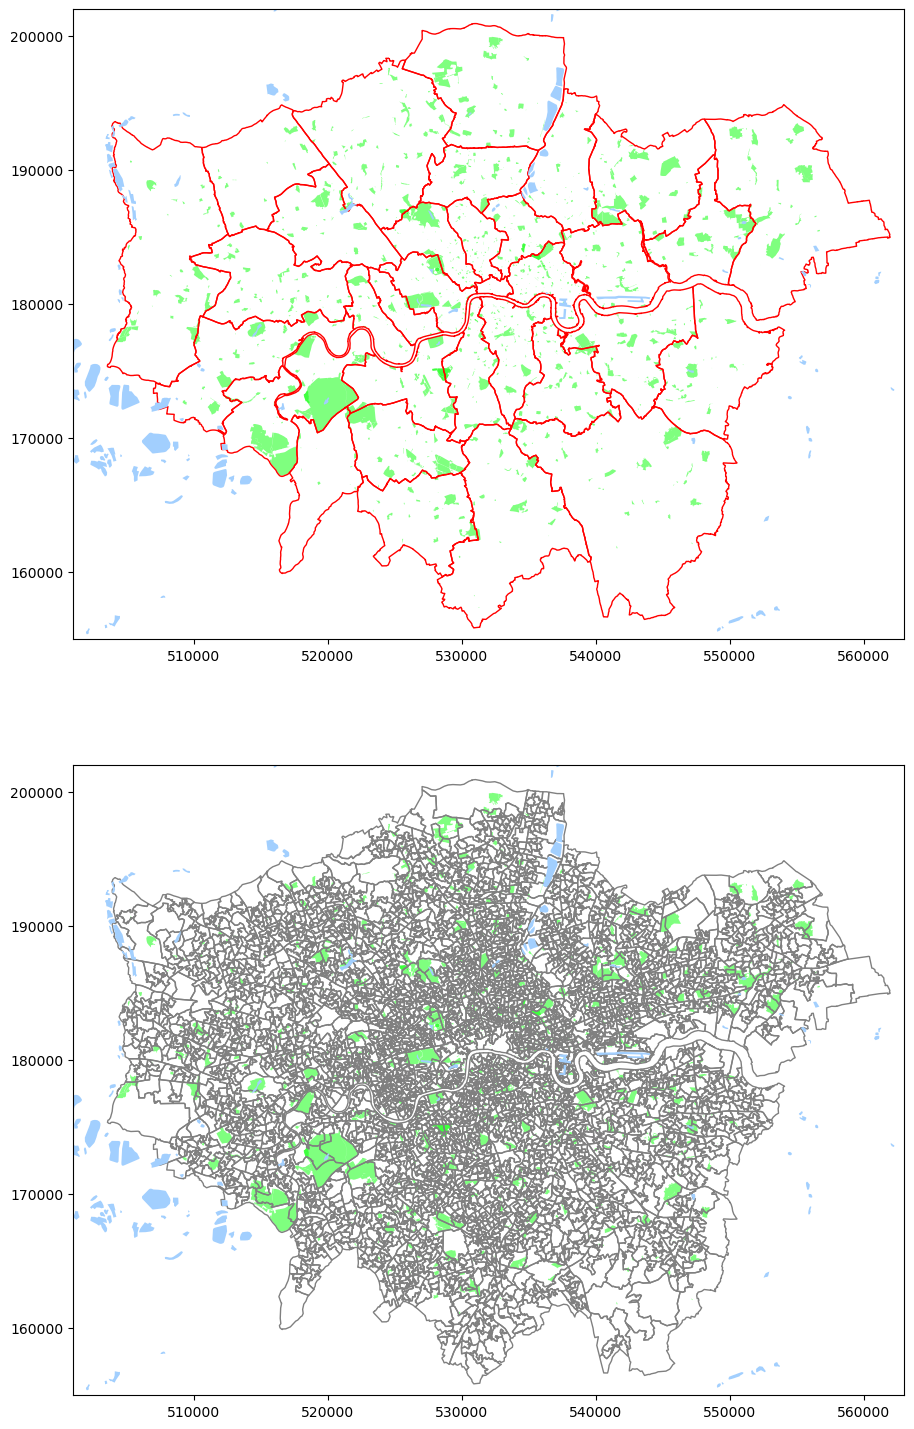

In [8]:
# Plot London map to confirm geometries are correct
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(24,18))

green.plot(edgecolor=None, facecolor=(0,1,0,0.5), ax=ax1)
boros.plot(edgecolor='red', facecolor='None',ax=ax1)
water.plot(edgecolor=None,facecolor='#a2cffe',ax=ax1)

green.plot(edgecolor=None, facecolor=(0,1,0,0.5), ax=ax2)
lsoa.plot(edgecolor='grey', facecolor='None',ax=ax2)
water.plot(edgecolor=None, facecolor='#a2cffe',ax=ax2)

# Set the x and y limits
ax1.set_xlim([501000, 563000])
ax1.set_ylim([155000, 202000])
ax2.set_xlim([501000, 563000])
ax2.set_ylim([155000, 202000])

Text(0.5, 1.0, 'Crimes in London, Sep 2023, Metropolitan Police')

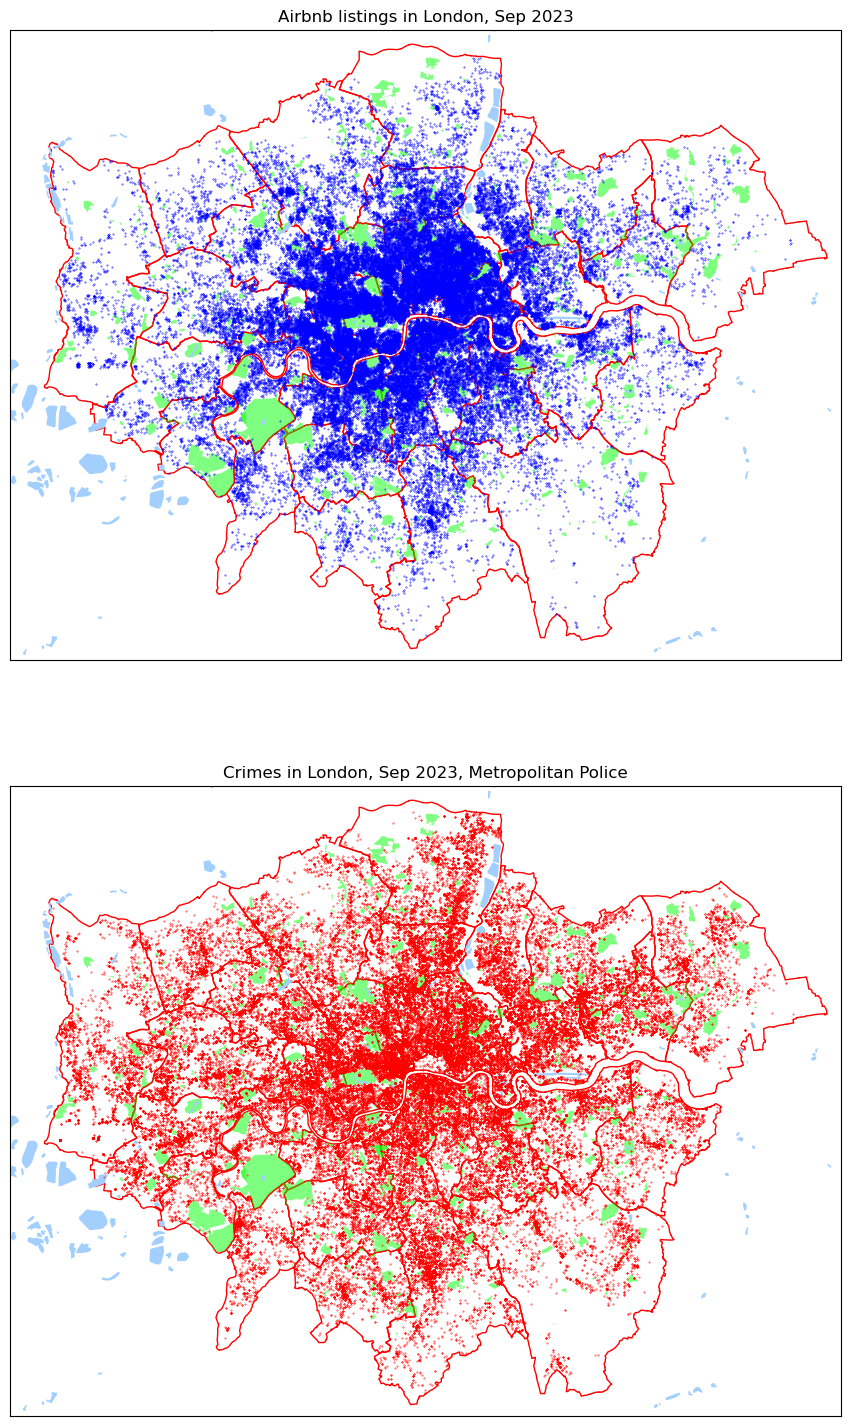

In [10]:
# Plot airbnb listings and crime incidents
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(24,18))

# Set the x and y limits
for ax in fig.get_axes():
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim([501000, 563000])
    ax.set_ylim([155000, 202000])
    boros.plot(edgecolor='red', facecolor='None',ax=ax)
    green.plot(edgecolor=None, facecolor=(0,1,0,0.5), ax=ax)
    water.plot(edgecolor=None,facecolor='#a2cffe',ax=ax)

listings.plot(ax=ax1, markersize=0.1,facecolor='blue')  
ax1.set_title('Airbnb listings in London, Sep 2023')

crime.plot(ax=ax2, markersize=0.1,facecolor='red')
ax2.set_title('Crimes in London, Sep 2023, Metropolitan Police')



In [24]:
# Clean crime data: outliers, and missing values, split into 2 types by severity
crime_serious = ['Burglary', 'Criminal damage and arson', 'Violence and sexual offences', 'Robbery', 'Theft from the person','Possession of weapons']
crime_minor = ['Anti-social behaviour', 'Public order', 'Vehicle crime', 'Drugs' , 'Shoplifting', 'Bicycle theft'] 

crime_sub = ['Burglary','Robbery','Theft from the person', 'Bicycle theft','Anti-social behaviour', 'Public order','Drugs']
# Need rationalization when writing the report

# Omit rows with Other Crime and Other Theft
crime = crime[~crime['Crime type'].isin(['Other theft','Other crime'])]
# Create a new column for crime type
crime['Severity'] = np.where(crime['Crime type'].isin(crime_serious), 'Serious', 'Minor')
crime['Tourism-relevance'] = np.where(crime['Crime type'].isin(crime_sub), 'Relevant', 'Less relevant')
crime.tail()

Unnamed: 0                                           Crime ID    Month  \
94954     3305419  e428fac4484cdbc20c86bf044f61ba05942d1846ada823...  2023-09   
94955     3305420  05c84401ec7d2129496a921746308384fe927f2232032a...  2023-09   
94956     3305421  dd42dcf68782f8aa553c15cac4f2ea7c13536a8b732852...  2023-09   
94957     3305422  9f2606828fc8e67fe813a95865c2bd69c7464878dfa7ce...  2023-09   
94958     3305423  db15663fb2259a3de5bb2d5147ee8b524b84bade3d76df...  2023-09   

                       Reported by                 Falls within  Longitude  \
94954  Metropolitan Police Service  Metropolitan Police Service  -0.136234   
94955  Metropolitan Police Service  Metropolitan Police Service  -0.137230   
94956  Metropolitan Police Service  Metropolitan Police Service  -0.136284   
94957  Metropolitan Police Service  Metropolitan Police Service  -0.136234   
94958  Metropolitan Police Service  Metropolitan Police Service  -0.133480   

        Latitude                            Location  LSOA code  \
94954  51.487435        On or near Chichester Street  E01035722   
94955  51.486309             On or near Parking Area  E01035722   
94956  51.485152           On or near Petrol Station  E01035722   
94957  51.487435        On or near Chichester Street  E01035722   
94958  51.486807  On or near St George'S Square Mews  E01035722   

              LSOA name                    Crime type  \
94954  Westminster 024G                  Public order   
94955  Westminster 024G         Theft from the person   
94956  Westminster 024G                 Vehicle crime   
94957  Westminster 024G  Violence and sexual offences   
94958  Westminster 024G  Violence and sexual offences   

                               Last outcome category  Context  \
94954                            Under investigation      NaN   
94955  Investigation complete; no suspect identified      NaN   
94956  Investigation complete; no suspect identified      NaN   
94957  Investigation complete; no suspect identified      NaN   
94958  Investigation complete; no suspect identified      NaN   

                            geometry Severity  
94954  POINT (529498.284 178144.827)    Minor  
94955  POINT (529432.323 178017.855)  Serious  
94956  POINT (529501.275 177890.866)    Minor  
94957  POINT (529498.284 178144.827)  Serious  
94958  POINT (529691.259 178079.863)  Serious

['Private room' 'Entire home/apt' 'Hotel room' 'Shared room']


/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

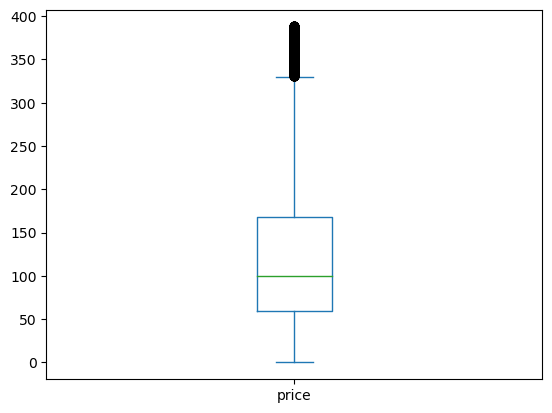

In [12]:
# Clean listings data: outliers, and missing values, split into 3 types by property type
print(listings.room_type.unique())
# Omit rows with Hotel room
listings = listings[~listings['room_type'].isin(['Hotel room'])]

# Transform price to float
if listings.price.dtype == 'O':
    listings.price = listings.price.str.replace('$','').str.replace(',','').astype(float).round(2)

# Trim outliers in terms of price based on interquartile range, because they are most likely they are not real listings
q1 = listings.price.quantile(0.25)
q3 = listings.price.quantile(0.75)
iqr = q3 - q1
listings = listings[(listings.price >= q1 - 1.5*iqr) & (listings.price <= q3 + 1.5*iqr)]
listings.price.plot.box()

### Descriptive statistics (Question #6 - 18 points)

*Objective:* 
Show the clustering of airbnb (by type), and crime incidents (by type). Show possible correlations between airbnb density and crime incidents
Approach: 

1. Split airbnb listing by 3 types (entire house/private room/shared room), and crime by 2 types (person vs property)
2. Plot out all the airbnb listings.
     - Heat map (KDE for each)
     - Descriptive statistics for each (LSOA min, max, mean, median)
3. Plot all the crime incidents, split by .
    - Heat map (KDE for each)
    - Descriptive statistics for each (LSOA min, max, mean, median)
4. Visual observation based on the heatmaps above where airbnb listings and crimes seem to overlap
5. Run correlations
-------------------------------------------------------------------------------

Task 1: Produce heat map for each type of airbnb listings

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

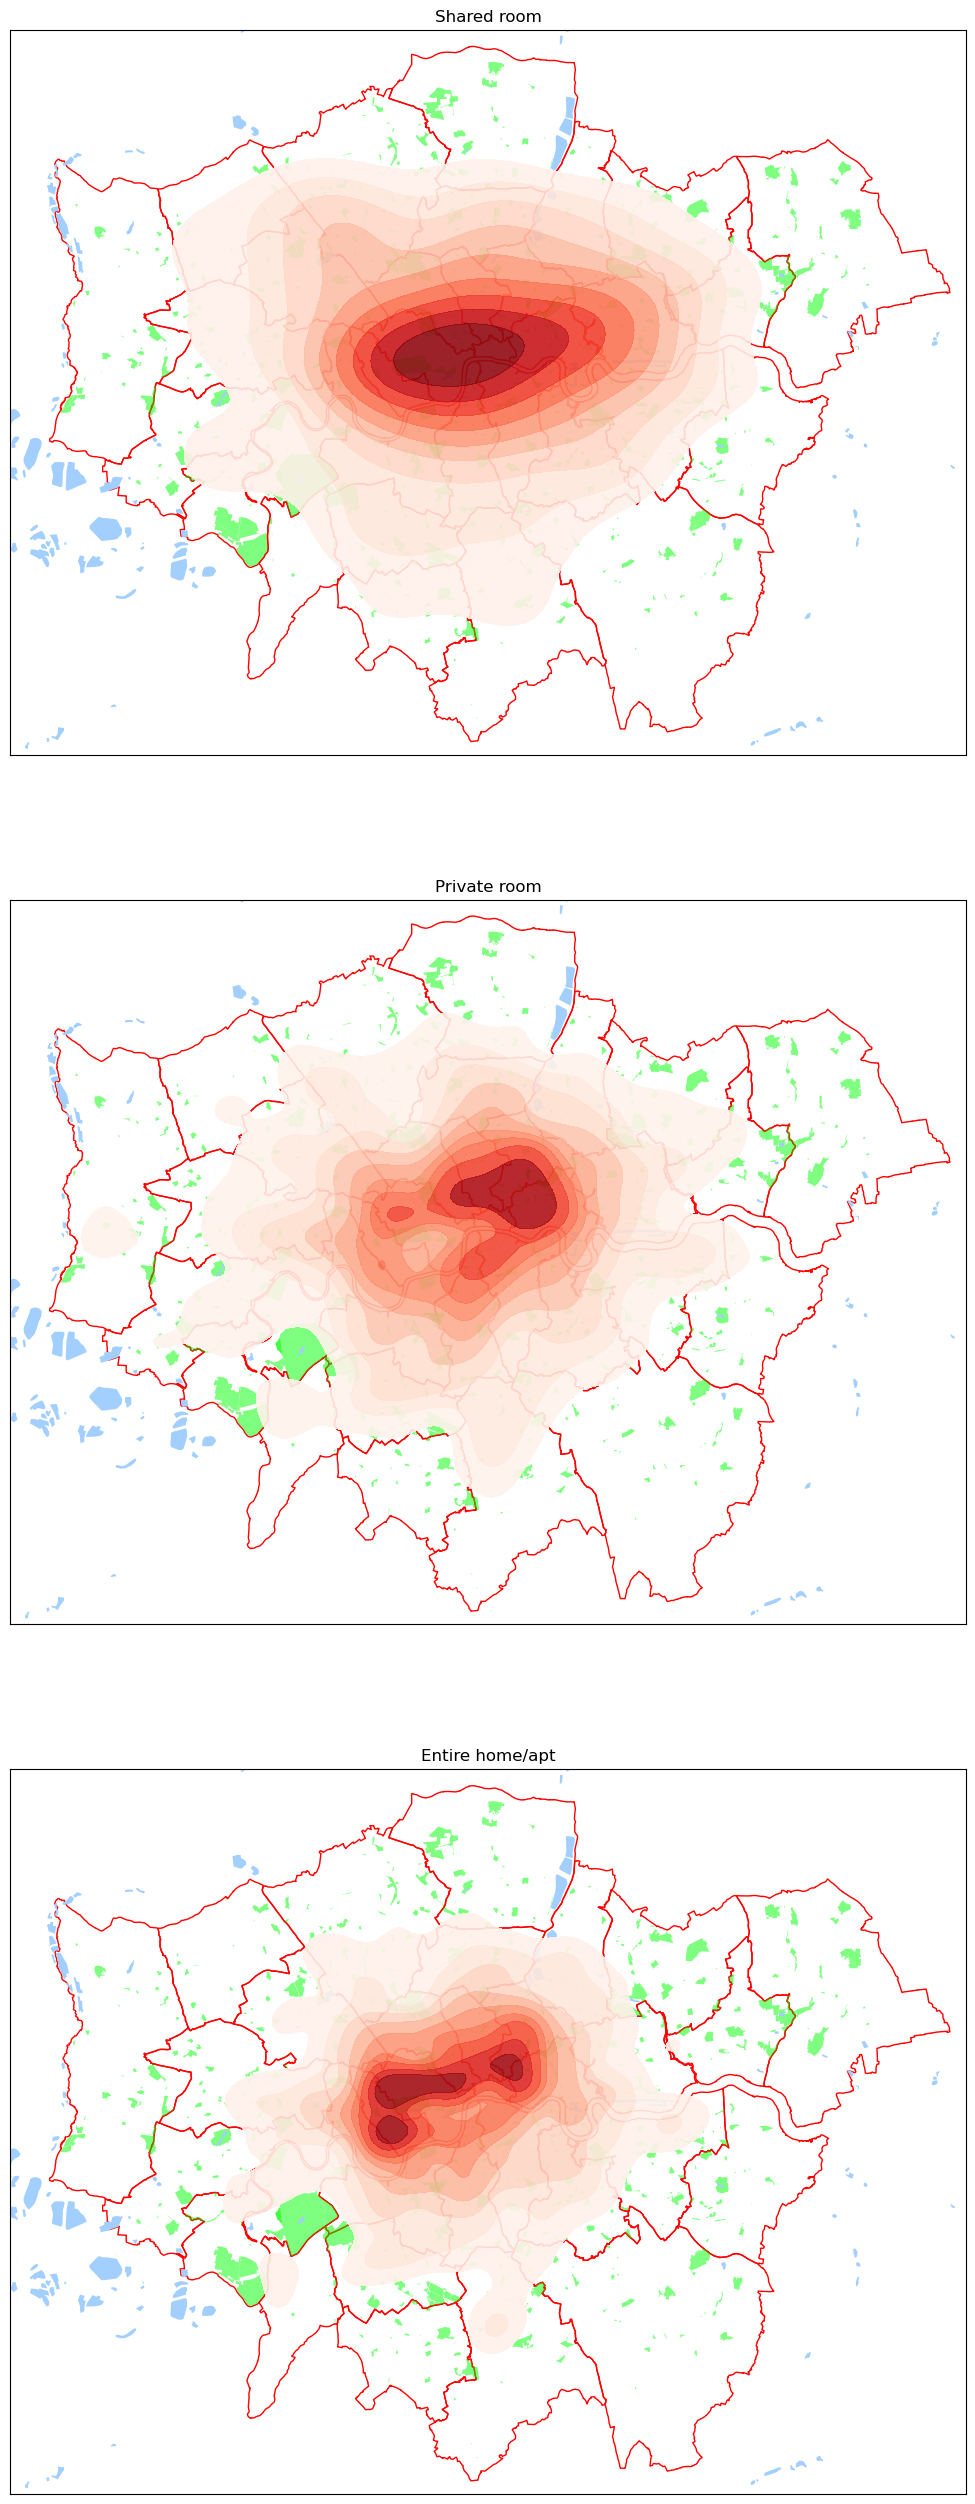

In [13]:
# kernel density estimation plot of listings for each room type on a map
# ['Private room' 'Entire home/apt' 'Shared room']

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(48,32))


for ax in fig.get_axes():
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim([501000, 563000])
    ax.set_ylim([155000, 202000])
    boros.plot(edgecolor='red', facecolor='None',ax=ax)
    green.plot(edgecolor=None, facecolor=(0,1,0,0.5), ax=ax)
    water.plot(edgecolor=None,facecolor='#a2cffe',ax=ax)


# Create thresholds
levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
# Kernel Density Estimation

kde = sns.kdeplot(
    ax=ax1,
    x=listings[listings.room_type=='Shared room'].geometry.x,
    y=listings[listings.room_type=='Shared room'].geometry.y,
    levels = levels, fill=True, cmap='Reds', alpha=0.9
)

kde = sns.kdeplot(
    ax=ax2,
    x=listings[listings.room_type=='Private room'].geometry.x,
    y=listings[listings.room_type=='Private room'].geometry.y,
    levels = levels, fill=True, cmap='Reds', alpha=0.9
)

kde = sns.kdeplot(
    ax=ax3,
    x=listings[listings.room_type=='Entire home/apt'].geometry.x,
    y=listings[listings.room_type=='Entire home/apt'].geometry.y,
    levels = levels, fill=True, cmap='Reds', alpha=0.9
)

ax1.set_title('Shared room')
ax2.set_title('Private room')
ax3.set_title('Entire home/apt')

plt.show()


Task 2: Produce heat map for each type of crime

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

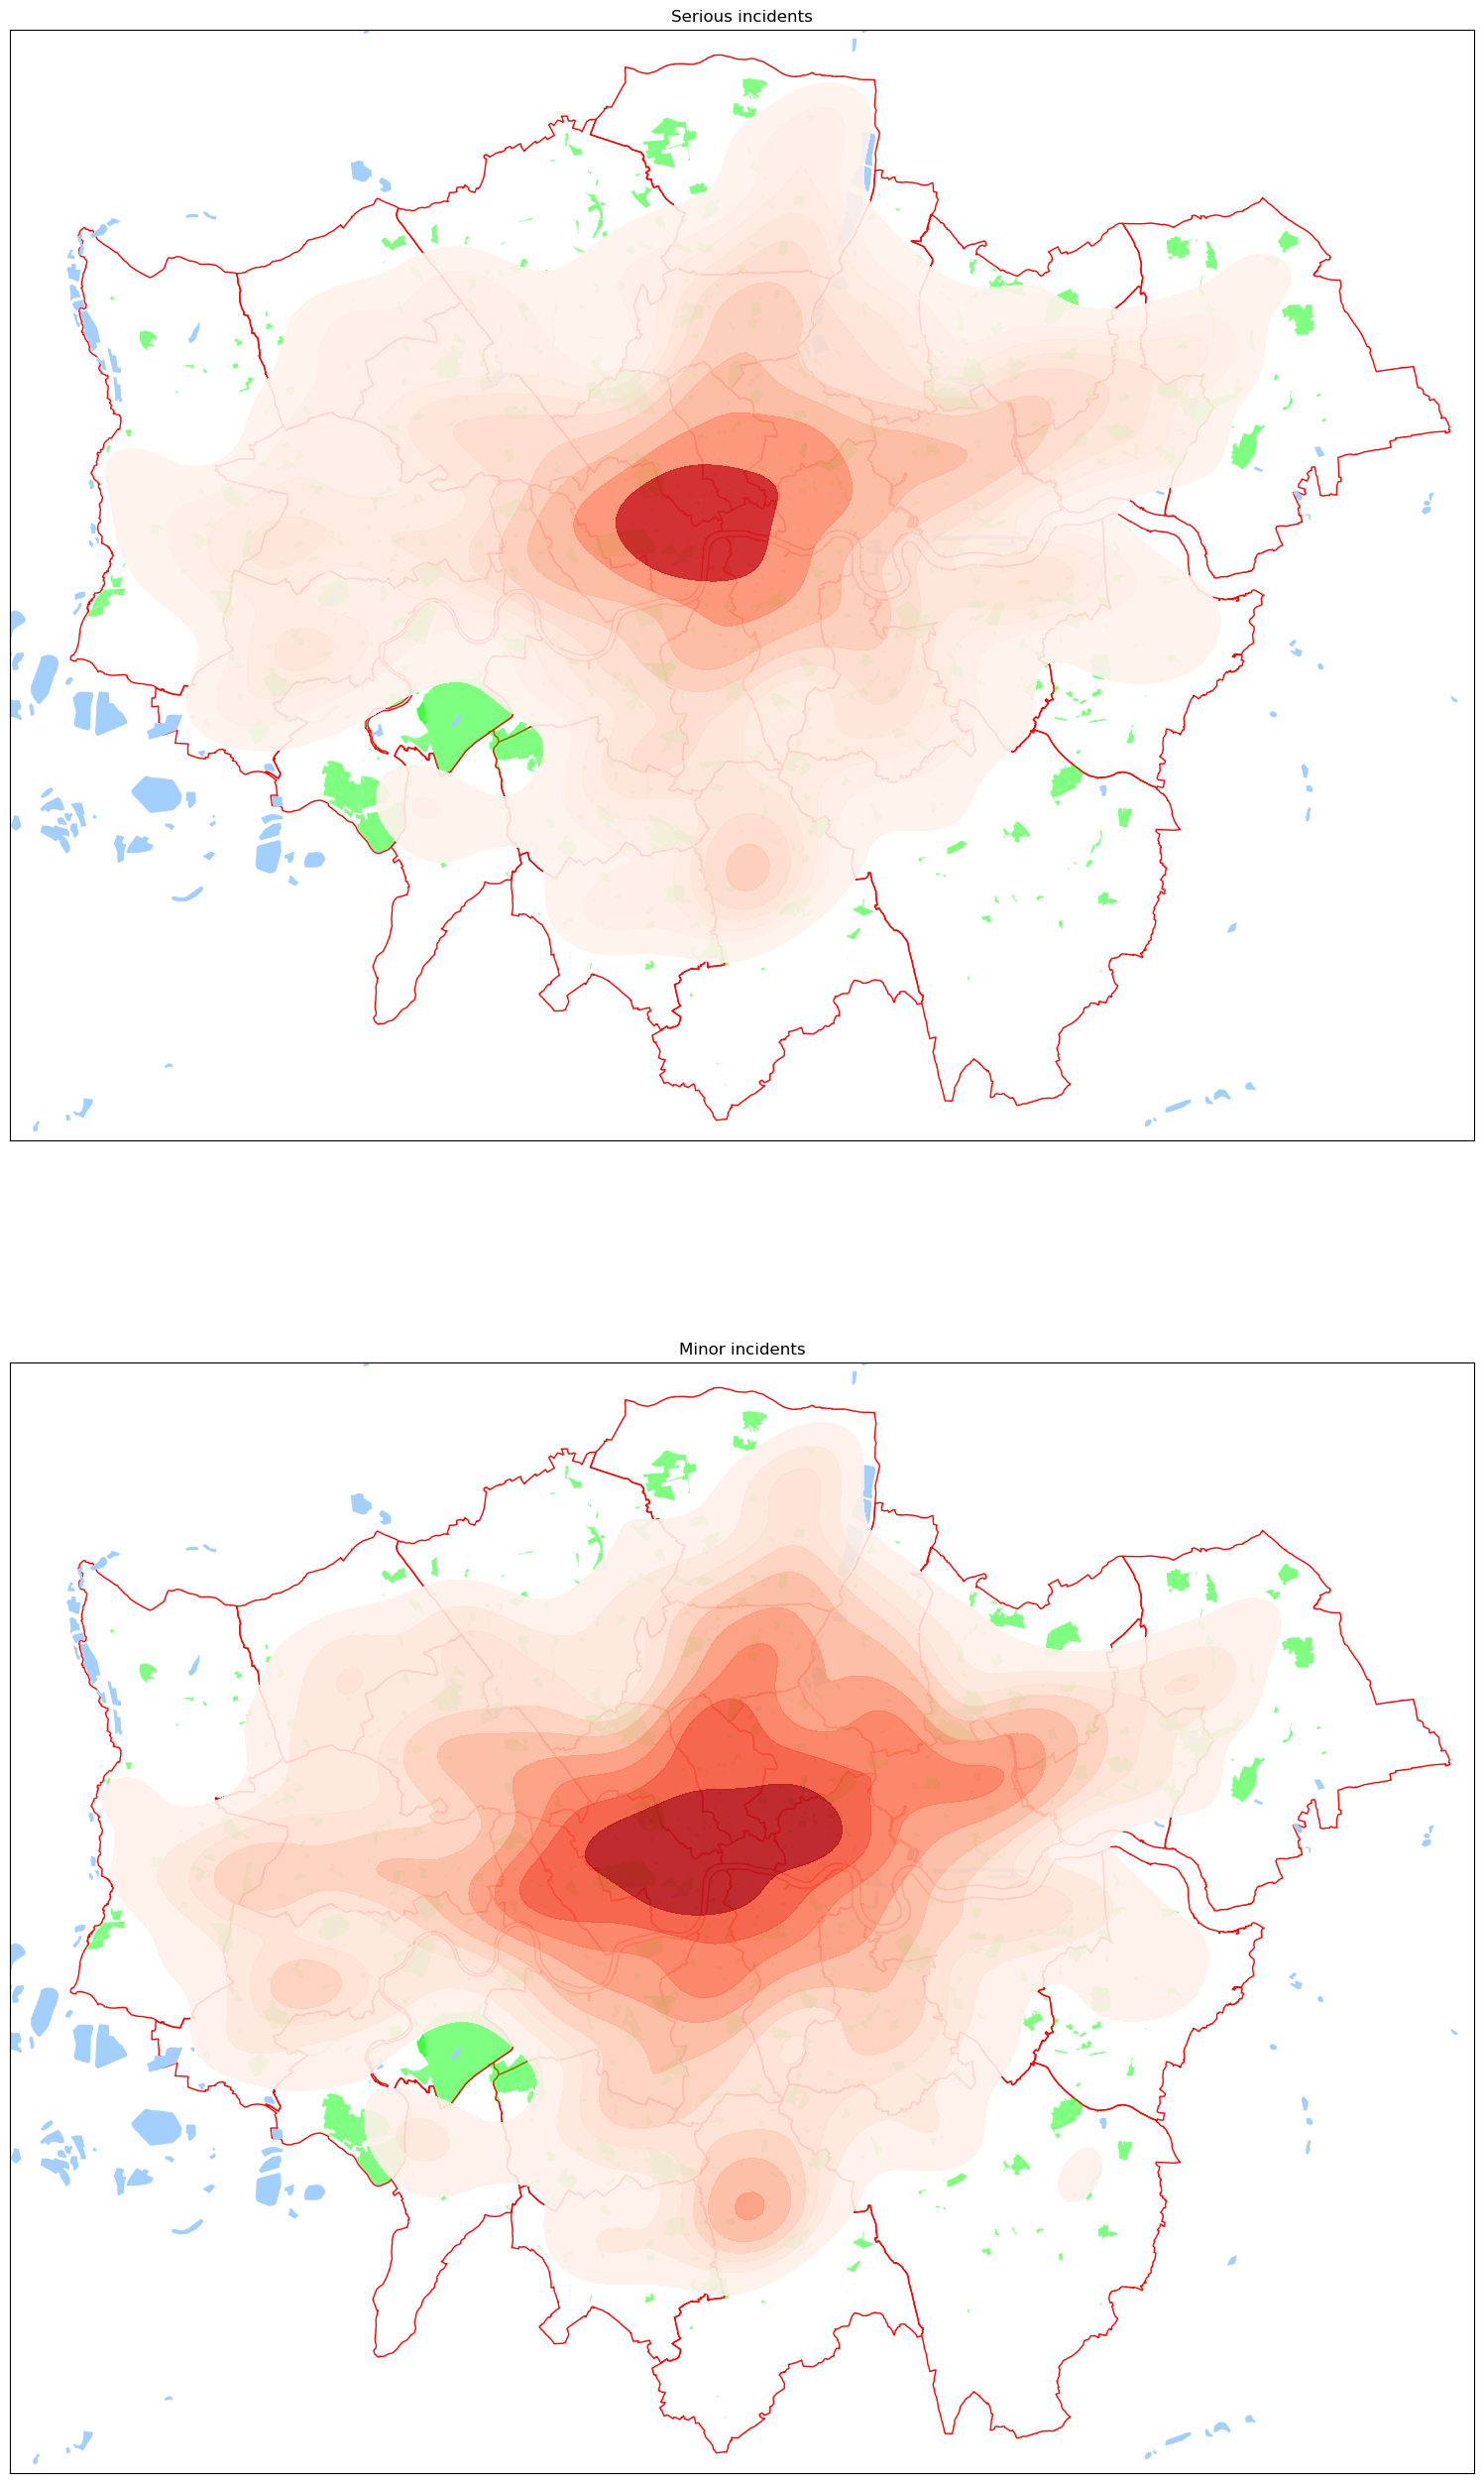

In [14]:
# kernel density estimation plot of crime for each type on a map
# Takes 2 minutes to run
# ['Serious' 'Minor']

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(48,32))

for ax in fig.get_axes():
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim([501000, 563000])
    ax.set_ylim([155000, 202000])
    boros.plot(edgecolor='red', facecolor='None',ax=ax)
    green.plot(edgecolor=None, facecolor=(0,1,0,0.5), ax=ax)
    water.plot(edgecolor=None,facecolor='#a2cffe',ax=ax)

# Create thresholds
levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
# Kernel Density Estimation

kde = sns.kdeplot(
    ax=ax1,
    x=crime[crime['Severity']=='Serious'].geometry.x,
    y=crime[crime['Severity']=='Serious'].geometry.y,
    levels = levels, fill=True, cmap='Reds', alpha=0.9
)

kde = sns.kdeplot(
    ax=ax2,
    x=crime[crime['Severity']=='Minor'].geometry.x,
    y=crime[crime['Severity']=='Minor'].geometry.y,
    levels = levels, fill=True, cmap='Reds', alpha=0.9
)

ax1.set_title('Serious incidents')
ax2.set_title('Minor incidents')

plt.show()


Task 3: Run correlations + spatial autocorrelation

In [34]:
lsoa_merge = lsoa

# Spatial crime listings and lsoa, summarise by count
sjoin_lsoa = gpd.sjoin(crime, lsoa_merge)
count_dict = sjoin_lsoa['LSOA21CD'].value_counts().to_dict() # count the values with value counts
lsoa_merge['crime_count'] = lsoa_merge['LSOA21CD'].map(count_dict) # map it back to lsoa

In [35]:
# Spatial join listings and lsoa, summarise by count
sjoin_lsoa = gpd.sjoin(listings, lsoa_merge)
count_dict = sjoin_lsoa['LSOA21CD'].value_counts().to_dict() # count the values with value counts
lsoa_merge['listing_count'] = lsoa_merge['LSOA21CD'].map(count_dict) # map it back to lsoa

In [36]:
# Spatial join crime by severity and lsoa, summarise by count
for s in ['Serious','Minor']:
    sjoin_lsoa = gpd.sjoin(crime[crime['Severity']==s], lsoa_merge)
    count_dict = sjoin_lsoa['LSOA21CD'].value_counts().to_dict() # count the values with value counts
    lsoa_merge['crime_count_'+s] = lsoa_merge['LSOA21CD'].map(count_dict) # map it back to lsoa_merge

# Sptial join listings by room type and lsoa, summarise by count
for r in ['Shared room','Private room','Entire home/apt']:
    sjoin_lsoa = gpd.sjoin(listings[listings['room_type']==r], lsoa_merge)
    count_dict = sjoin_lsoa['LSOA21CD'].value_counts().to_dict() # count the values with value counts
    lsoa_merge['listing_count_'+r] = lsoa_merge['LSOA21CD'].map(count_dict) # map it back to lsoa_merge

In [37]:
# Change NA to 0
lsoa_merge = lsoa_merge.fillna(0)
lsoa_merge.head()

OBJECTID   LSOA21CD                   LSOA21NM  \
0         1  E01000001        City of London 001A   
1         2  E01000002        City of London 001B   
2         3  E01000003        City of London 001C   
3         4  E01000005        City of London 001E   
4         5  E01000006  Barking and Dagenham 016A   

                               GlobalID  \
0  f1865556-4e62-48e3-a025-d93a40f15e46   
1  83e78aad-ee05-44a5-a8d3-077de6ed4053   
2  69c457df-229e-4446-9577-95ac1c9be694   
3  d537d59f-237a-45ed-a514-b0ab2a93e510   
4  8d0081fe-69e2-48ac-aaf9-fd270d60e339   

                                            geometry  crime_count  \
0  POLYGON ((532105.312 182010.574, 532162.491 18...          0.0   
1  POLYGON ((532634.497 181926.016, 532619.141 18...          2.0   
2  POLYGON ((532135.138 182198.131, 532158.250 18...          1.0   
3  POLYGON ((533808.018 180767.774, 533649.037 18...         14.0   
4  POLYGON ((545122.049 184314.931, 545271.849 18...          3.0   

   listing_count  crime_count_Serious  crime_count_Minor  \
0           16.0                  0.0                0.0   
1           14.0                  1.0                1.0   
2           16.0                  1.0                0.0   
3           99.0                  5.0                9.0   
4            7.0                  1.0                2.0   

   listing_count_Shared room  listing_count_Private room  \
0                        1.0                         5.0   
1                        0.0                         0.0   
2                        0.0                         4.0   
3                        0.0                        20.0   
4                        0.0                         6.0   

   listing_count_Entire home/apt  
0                           10.0  
1                           14.0  
2                           12.0  
3                           79.0  
4                            1.0

Text(0.5, 1.0, 'Airbnb Listing count by LSOA, Sep 2023')

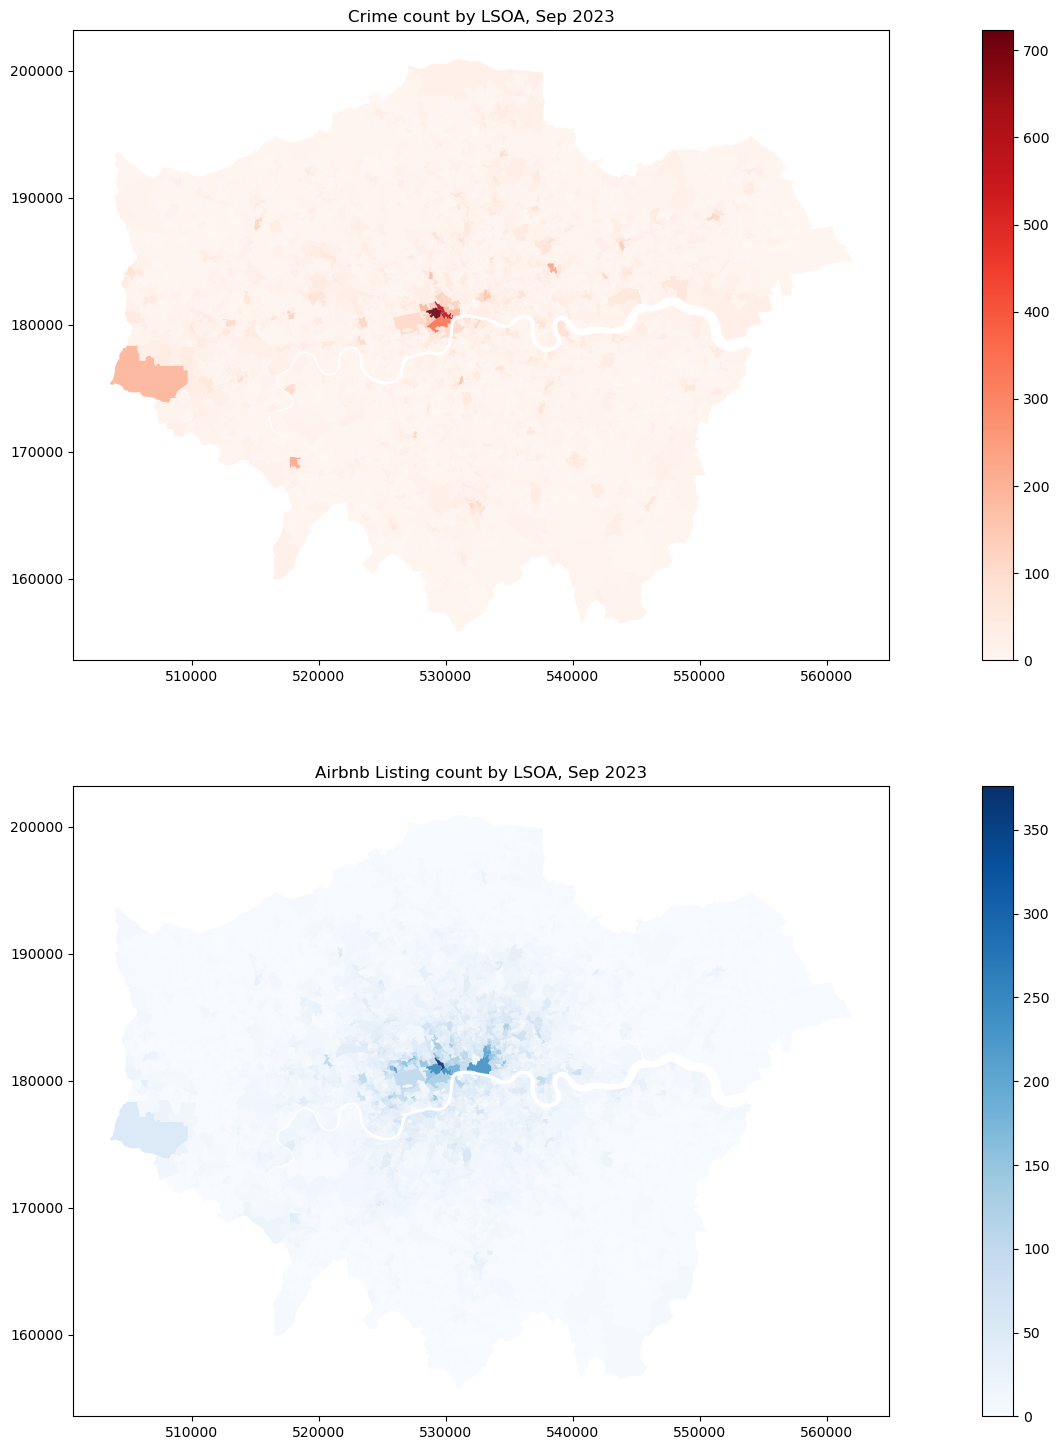

In [19]:
# Plot crime on x and listings y for lsoa_merge
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(24,18))
lsoa_merge.plot(ax=ax1, column='crime_count', legend=True, cmap='Reds', alpha=0.9)
lsoa_merge.plot(ax=ax2, column='listing_count', legend=True, cmap='Blues', alpha=0.9)
ax1.set_title('Crime count by LSOA, Sep 2023')
ax2.set_title('Airbnb Listing count by LSOA, Sep 2023')


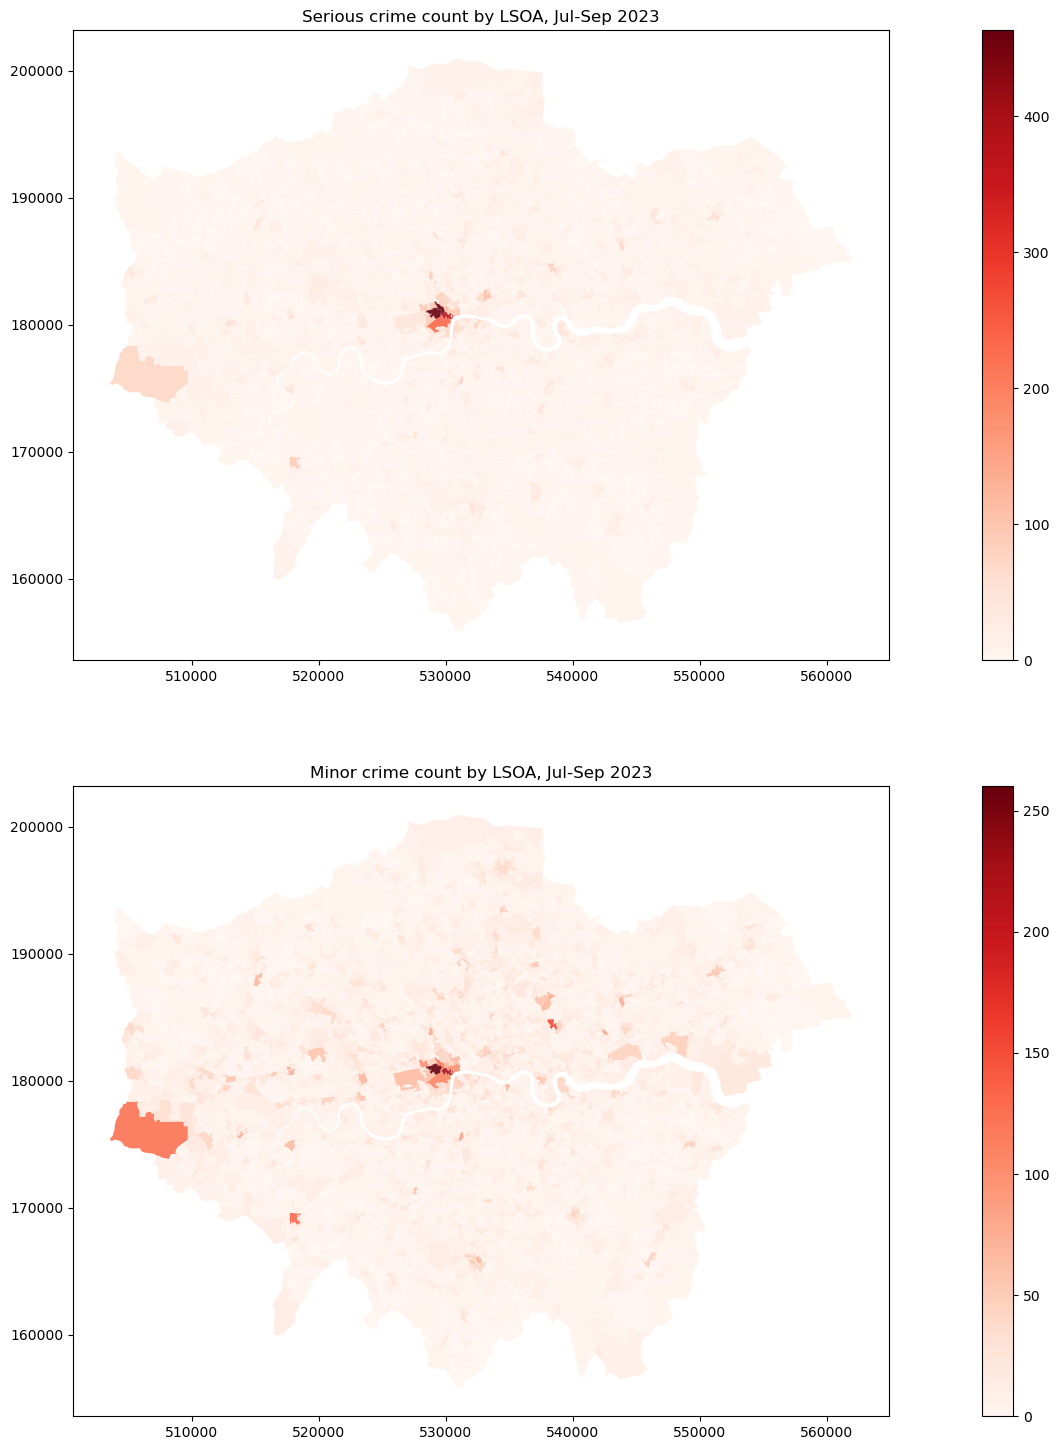

In [45]:
# Plot 2 crime types LSOA
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(24,18))

lsoa_merge.plot(ax=ax1, column='crime_count_Serious', legend=True, cmap='Reds', alpha=0.9)
lsoa_merge.plot(ax=ax2, column='crime_count_Minor', legend=True, cmap='Reds', alpha=0.9)

ax1.set_title('Serious crime count by LSOA, Jul-Sep 2023')
ax2.set_title('Minor crime count by LSOA, Jul-Sep 2023')

plt.show()

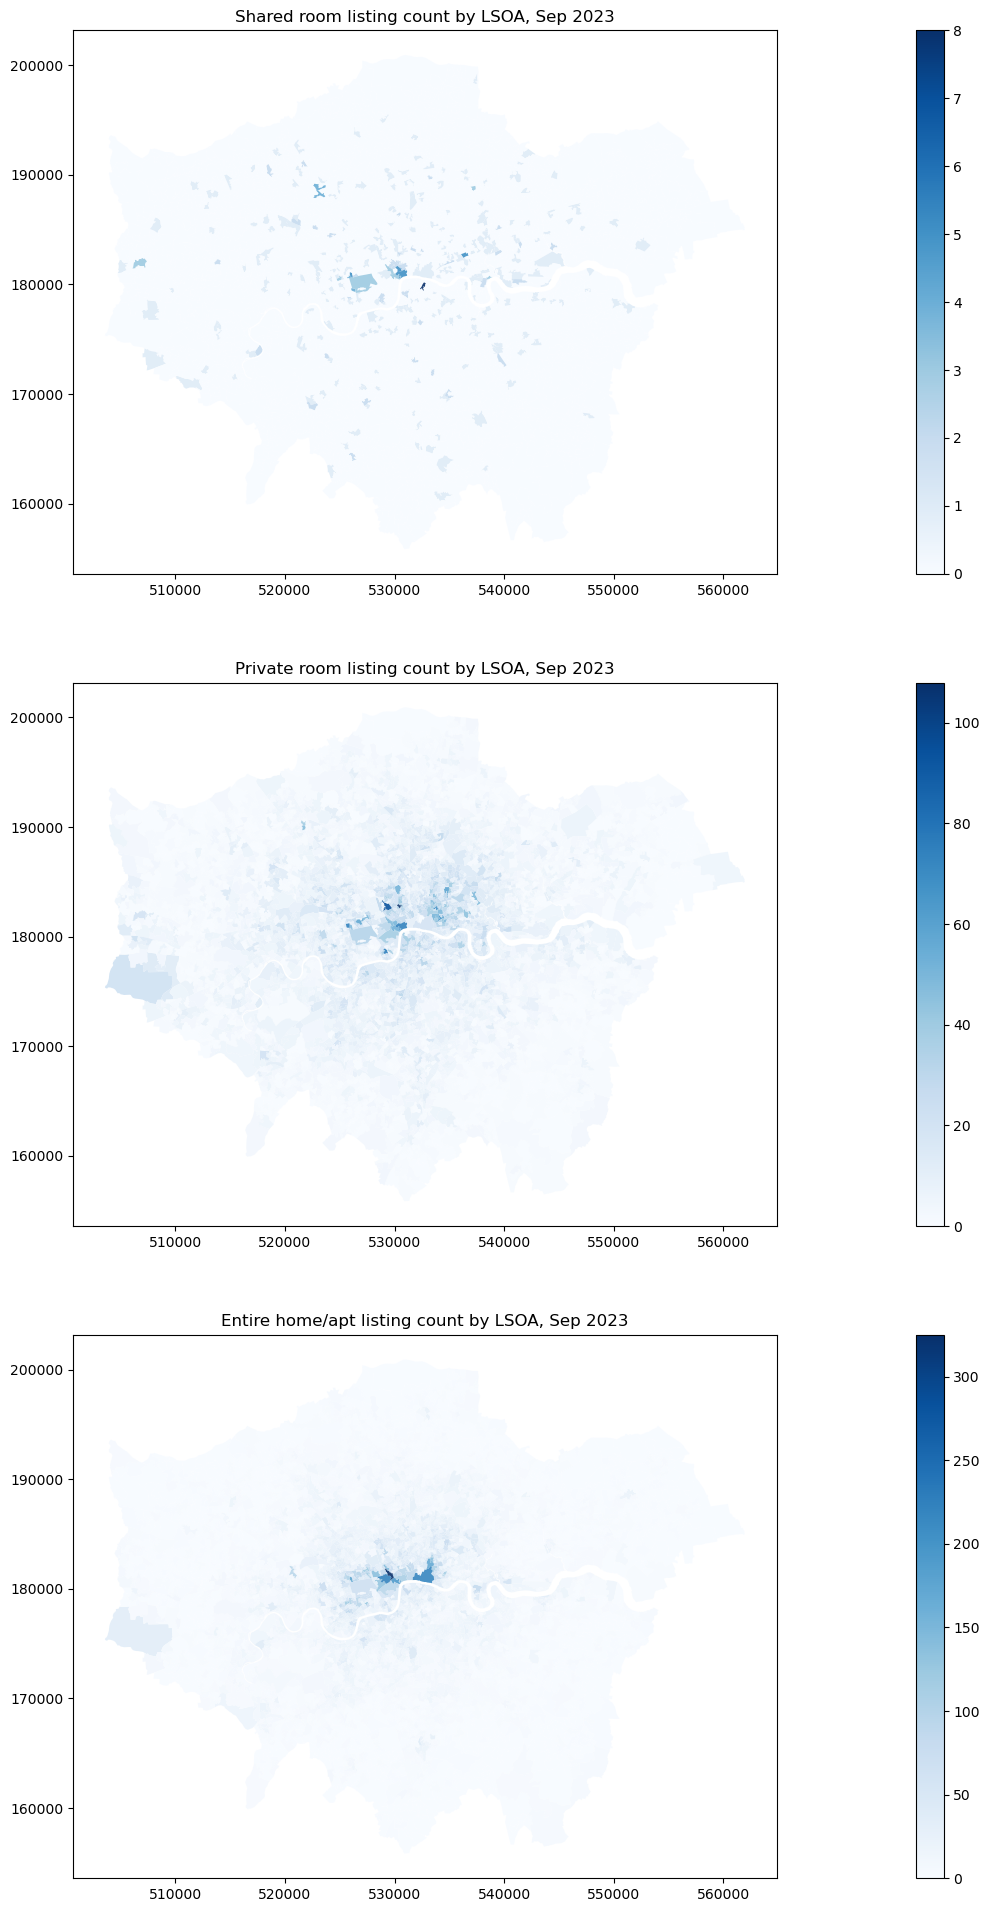

In [23]:
# Plot 3 listing types by LSOA
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(36,24))

lsoa_merge.plot(ax=ax1, column='listing_count_Shared room', legend=True, cmap='Blues', alpha=0.9)
lsoa_merge.plot(ax=ax2, column='listing_count_Private room', legend=True, cmap='Blues', alpha=0.9)
lsoa_merge.plot(ax=ax3, column='listing_count_Entire home/apt', legend=True, cmap='Blues', alpha=0.9)


ax1.set_title('Shared room listing count by LSOA, Sep 2023')
ax2.set_title('Private room listing count by LSOA, Sep 2023')
ax3.set_title('Entire home/apt listing count by LSOA, Sep 2023')

plt.show()

Text(0.5, 1.0, 'Correlation Matrix - Listings type vs Crime severity')

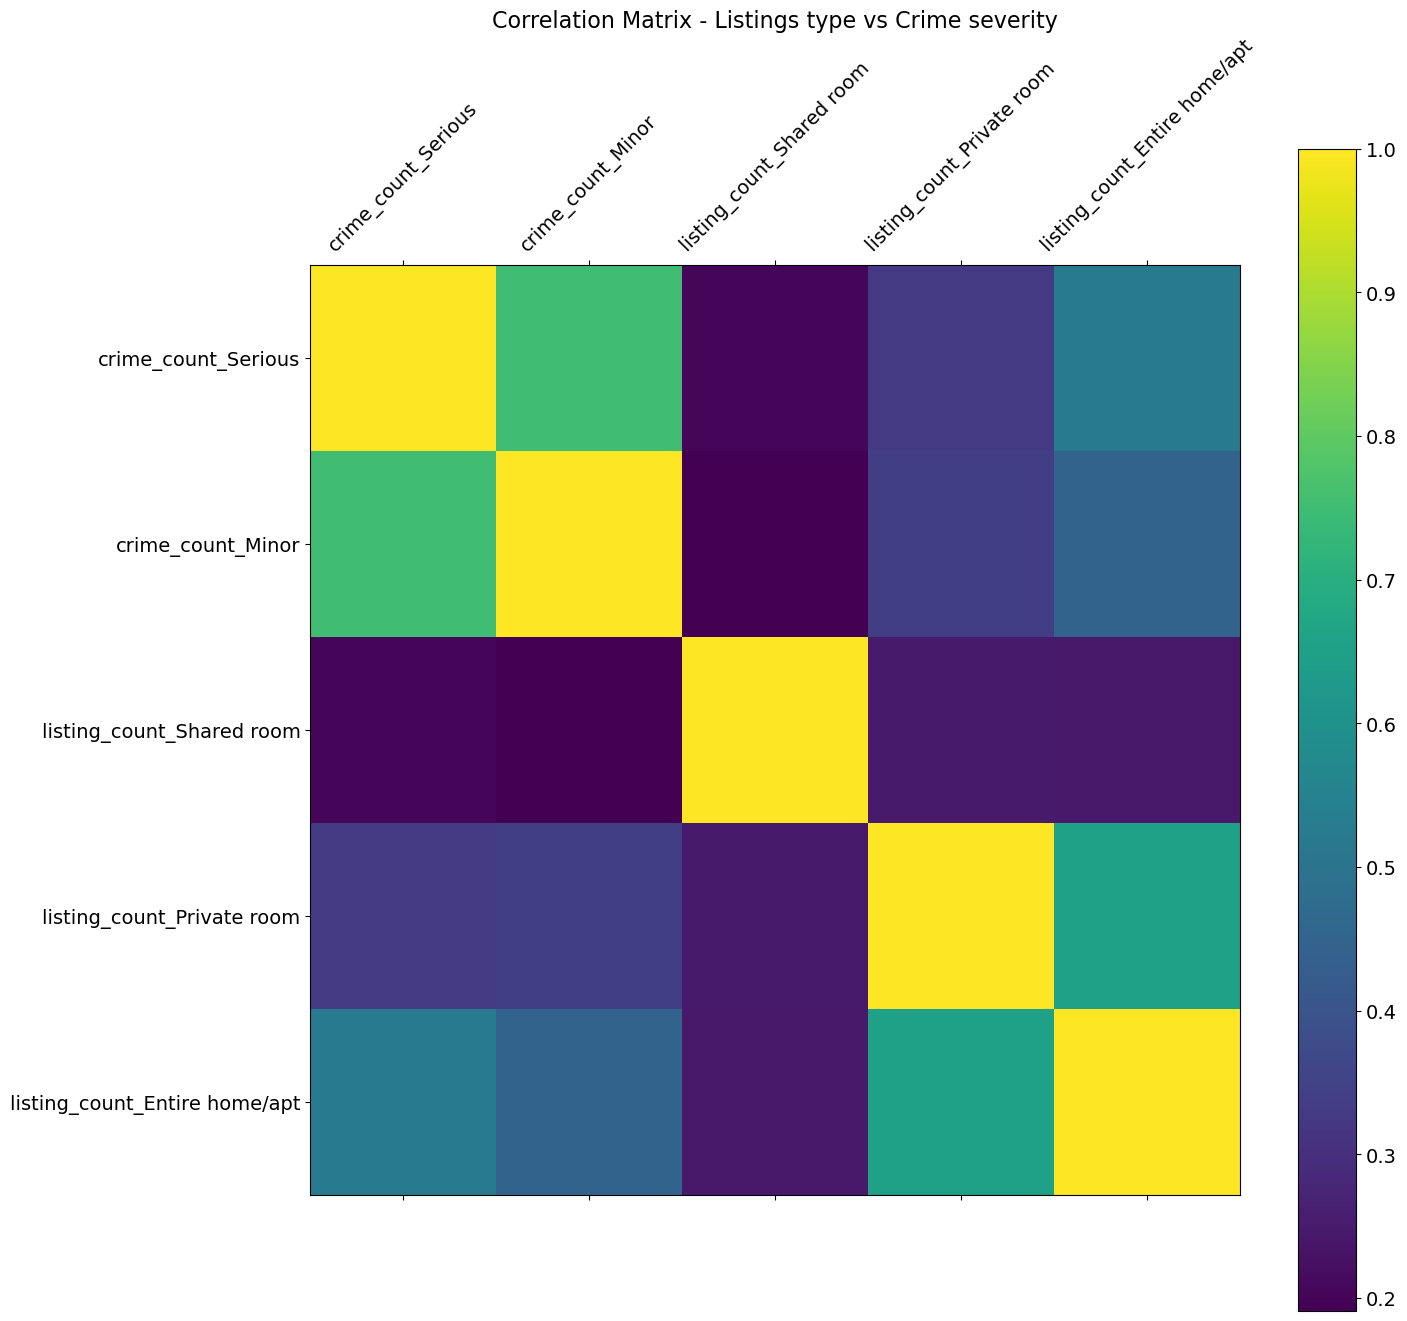

In [25]:
# Correlation matrix

# Subset last 5 columns
lsoa_merge_sub = lsoa_merge.iloc[:,-5:]

f = plt.figure(figsize=(15, 15)) # creates a new figure, sets length and width

plt.matshow(lsoa_merge_sub.corr(numeric_only=True), fignum=f.number) # matshow - creates matrix plot
plt.xticks(range(lsoa_merge_sub.select_dtypes(['number']).shape[1]), lsoa_merge_sub.select_dtypes(['number']).columns, fontsize=14, rotation=45) # add the x axis label
plt.yticks(range(lsoa_merge_sub.select_dtypes(['number']).shape[1]), lsoa_merge_sub.select_dtypes(['number']).columns, fontsize=14) # add the y axis label

# select_dtypes(['number']) - choose the numeric variables
cb = plt.colorbar() # add a legend to the right hand (default position)
cb.ax.tick_params(labelsize=14) # label size
plt.title('Correlation Matrix - Listings type vs Crime severity', fontsize=16) # add the title


In [26]:
lsoa_stat.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Data columns (total 235 columns):
 #    Column                                                                           Dtype 
---   ------                                                                           ----- 
 0    LSOA code                                                                        object
 1    local authority code                                                             object
 2    local authority name                                                             object
 3    All households                                                                   int64 
 4    Detached                                                                         int64 
 5    Semi-detached                                                                    int64 
 6    Terraced                                                                         int64 
 7    Purpose built flat                      

In [38]:
lsoa_merge.head()

OBJECTID   LSOA21CD                   LSOA21NM  \
0         1  E01000001        City of London 001A   
1         2  E01000002        City of London 001B   
2         3  E01000003        City of London 001C   
3         4  E01000005        City of London 001E   
4         5  E01000006  Barking and Dagenham 016A   

                               GlobalID  \
0  f1865556-4e62-48e3-a025-d93a40f15e46   
1  83e78aad-ee05-44a5-a8d3-077de6ed4053   
2  69c457df-229e-4446-9577-95ac1c9be694   
3  d537d59f-237a-45ed-a514-b0ab2a93e510   
4  8d0081fe-69e2-48ac-aaf9-fd270d60e339   

                                            geometry  crime_count  \
0  POLYGON ((532105.312 182010.574, 532162.491 18...          0.0   
1  POLYGON ((532634.497 181926.016, 532619.141 18...          2.0   
2  POLYGON ((532135.138 182198.131, 532158.250 18...          1.0   
3  POLYGON ((533808.018 180767.774, 533649.037 18...         14.0   
4  POLYGON ((545122.049 184314.931, 545271.849 18...          3.0   

   listing_count  crime_count_Serious  crime_count_Minor  \
0           16.0                  0.0                0.0   
1           14.0                  1.0                1.0   
2           16.0                  1.0                0.0   
3           99.0                  5.0                9.0   
4            7.0                  1.0                2.0   

   listing_count_Shared room  listing_count_Private room  \
0                        1.0                         5.0   
1                        0.0                         0.0   
2                        0.0                         4.0   
3                        0.0                        20.0   
4                        0.0                         6.0   

   listing_count_Entire home/apt  
0                           10.0  
1                           14.0  
2                           12.0  
3                           79.0  
4                            1.0

In [40]:
lsoa_merge1.info(verbose=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4994 entries, 0 to 4993
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   OBJECTID                       4994 non-null   int64   
 1   LSOA21CD                       4994 non-null   object  
 2   LSOA21NM                       4994 non-null   object  
 3   GlobalID                       4994 non-null   object  
 4   geometry                       4994 non-null   geometry
 5   crime_count                    4994 non-null   float64 
 6   listing_count                  4994 non-null   float64 
 7   crime_count_Serious            4994 non-null   float64 
 8   crime_count_Minor              4994 non-null   float64 
 9   listing_count_Shared room      4994 non-null   float64 
 10  listing_count_Private room     4994 non-null   float64 
 11  listing_count_Entire home/apt  4994 non-null   float64 
 12  All usual residents       

In [41]:
# Merge column 'All usual residents' from lsoa_stat to lsoa_merge by LSOA21CD
lsoa_merge1 = lsoa_merge.merge(lsoa_stat[['LSOA code','All usual residents']], left_on = 'LSOA21CD',right_on='LSOA code', how='left').drop(columns=['LSOA code'])

# Add density for each column in lsoa_merge using 'All usual residents' in lsoa_stat
lsoa_merge1['crime_density'] = lsoa_merge1['crime_count']/lsoa_merge1['All usual residents']
lsoa_merge1['listing_density'] = lsoa_merge1['listing_count']/lsoa_merge1['All usual residents']
lsoa_merge1['crime_density_Serious'] = lsoa_merge1['crime_count_Serious']/lsoa_merge1['All usual residents']
lsoa_merge1['crime_density_Minor'] = lsoa_merge1['crime_count_Minor']/lsoa_merge1['All usual residents']
lsoa_merge1['listing_density_Shared room'] = lsoa_merge1['listing_count_Shared room']/lsoa_merge1['All usual residents']
lsoa_merge1['listing_density_Private room'] = lsoa_merge1['listing_count_Private room']/lsoa_merge1['All usual residents']
lsoa_merge1['listing_density_Entire home/apt'] = lsoa_merge1['listing_count_Entire home/apt']/lsoa_merge1['All usual residents']

# Drop columns 
lsoa_merge1.head()

OBJECTID   LSOA21CD                   LSOA21NM  \
0         1  E01000001        City of London 001A   
1         2  E01000002        City of London 001B   
2         3  E01000003        City of London 001C   
3         4  E01000005        City of London 001E   
4         5  E01000006  Barking and Dagenham 016A   

                               GlobalID  \
0  f1865556-4e62-48e3-a025-d93a40f15e46   
1  83e78aad-ee05-44a5-a8d3-077de6ed4053   
2  69c457df-229e-4446-9577-95ac1c9be694   
3  d537d59f-237a-45ed-a514-b0ab2a93e510   
4  8d0081fe-69e2-48ac-aaf9-fd270d60e339   

                                            geometry  crime_count  \
0  POLYGON ((532105.312 182010.574, 532162.491 18...          0.0   
1  POLYGON ((532634.497 181926.016, 532619.141 18...          2.0   
2  POLYGON ((532135.138 182198.131, 532158.250 18...          1.0   
3  POLYGON ((533808.018 180767.774, 533649.037 18...         14.0   
4  POLYGON ((545122.049 184314.931, 545271.849 18...          3.0   

   listing_count  crime_count_Serious  crime_count_Minor  \
0           16.0                  0.0                0.0   
1           14.0                  1.0                1.0   
2           16.0                  1.0                0.0   
3           99.0                  5.0                9.0   
4            7.0                  1.0                2.0   

   listing_count_Shared room  listing_count_Private room  \
0                        1.0                         5.0   
1                        0.0                         0.0   
2                        0.0                         4.0   
3                        0.0                        20.0   
4                        0.0                         6.0   

   listing_count_Entire home/apt  All usual residents  crime_density  \
0                           10.0                 1473       0.000000   
1                           14.0                 1382       0.001447   
2                           12.0                 1613       0.000620   
3                           79.0                 1111       0.012601   
4                            1.0                 1840       0.001630   

   listing_density  crime_density_Serious  crime_density_Minor  \
0         0.010862               0.000000             0.000000   
1         0.010130               0.000724             0.000724   
2         0.009919               0.000620             0.000000   
3         0.089109               0.004500             0.008101   
4         0.003804               0.000543             0.001087   

   listing_density_Shared room  listing_density_Private room  \
0                     0.000679                      0.003394   
1                     0.000000                      0.000000   
2                     0.000000                      0.002480   
3                     0.000000                      0.018002   
4                     0.000000                      0.003261   

   listing_density_Entire home/apt  
0                         0.006789  
1                         0.010130  
2                         0.007440  
3                         0.071107  
4                         0.000543

Text(0.5, 1.0, 'Airbnb Listing density by LSOA, Sep 2023')

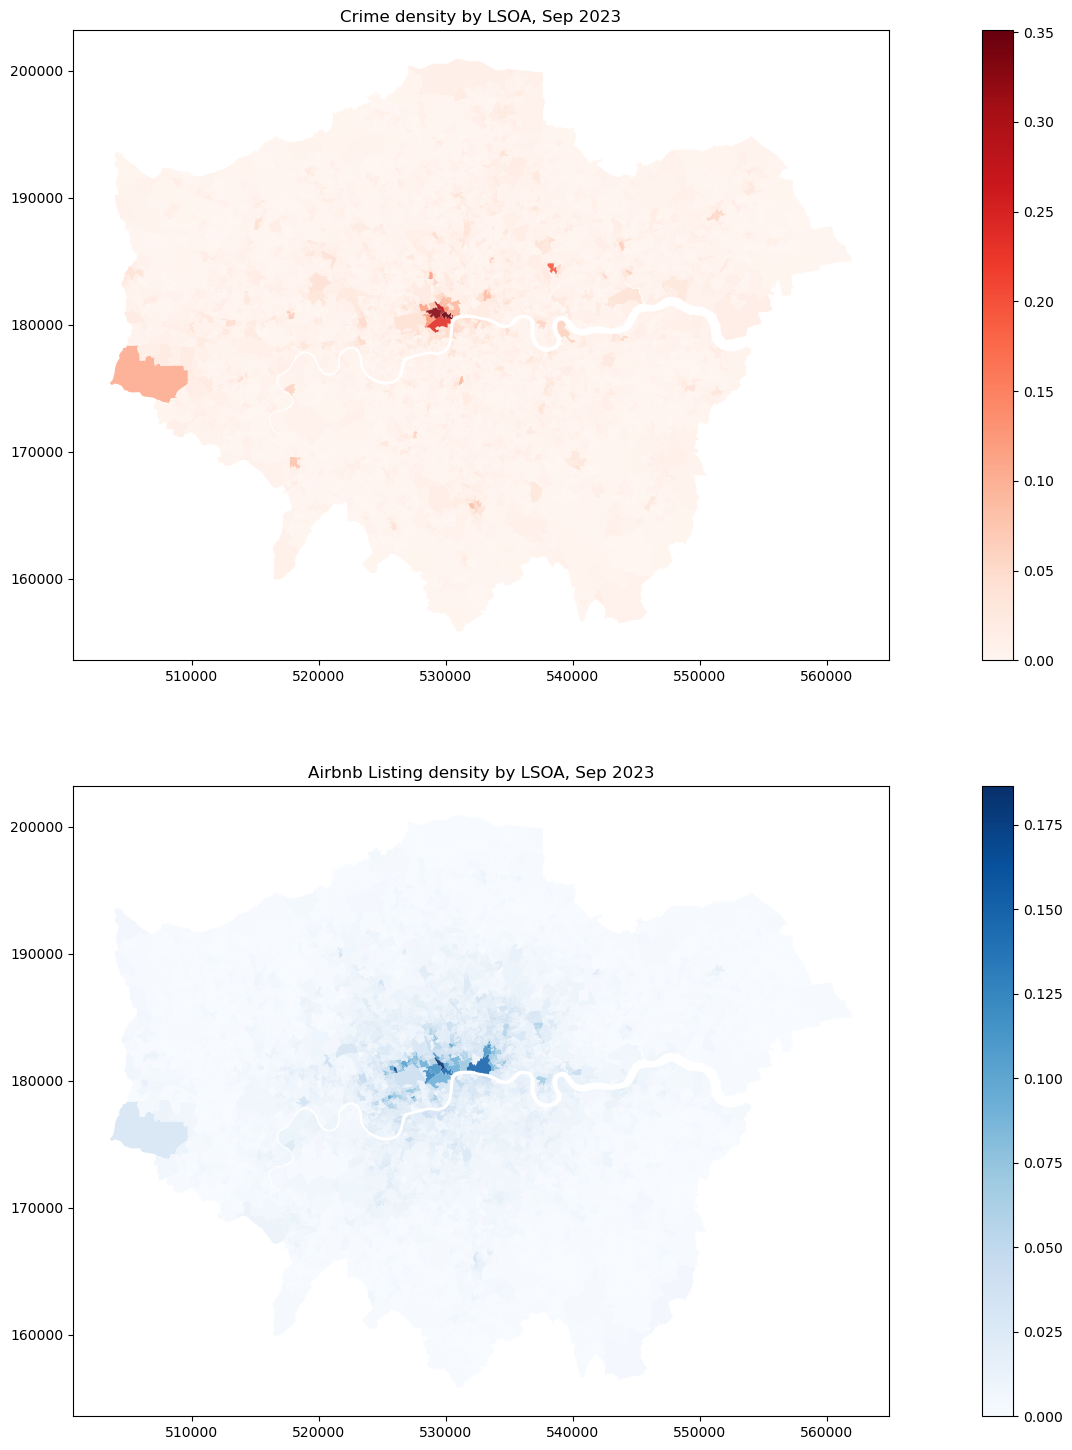

In [42]:
# Plot crime density on x and listings density y for lsoa_merge1
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(24,18))
lsoa_merge1.plot(ax=ax1, column='crime_density', legend=True, cmap='Reds', alpha=0.9)
lsoa_merge1.plot(ax=ax2, column='listing_density', legend=True, cmap='Blues', alpha=0.9)
ax1.set_title('Crime density by LSOA, Sep 2023')
ax2.set_title('Airbnb Listing density by LSOA, Sep 2023')

Text(0.5, 1.0, 'Correlation Matrix - Listings type vs Crime severity density')

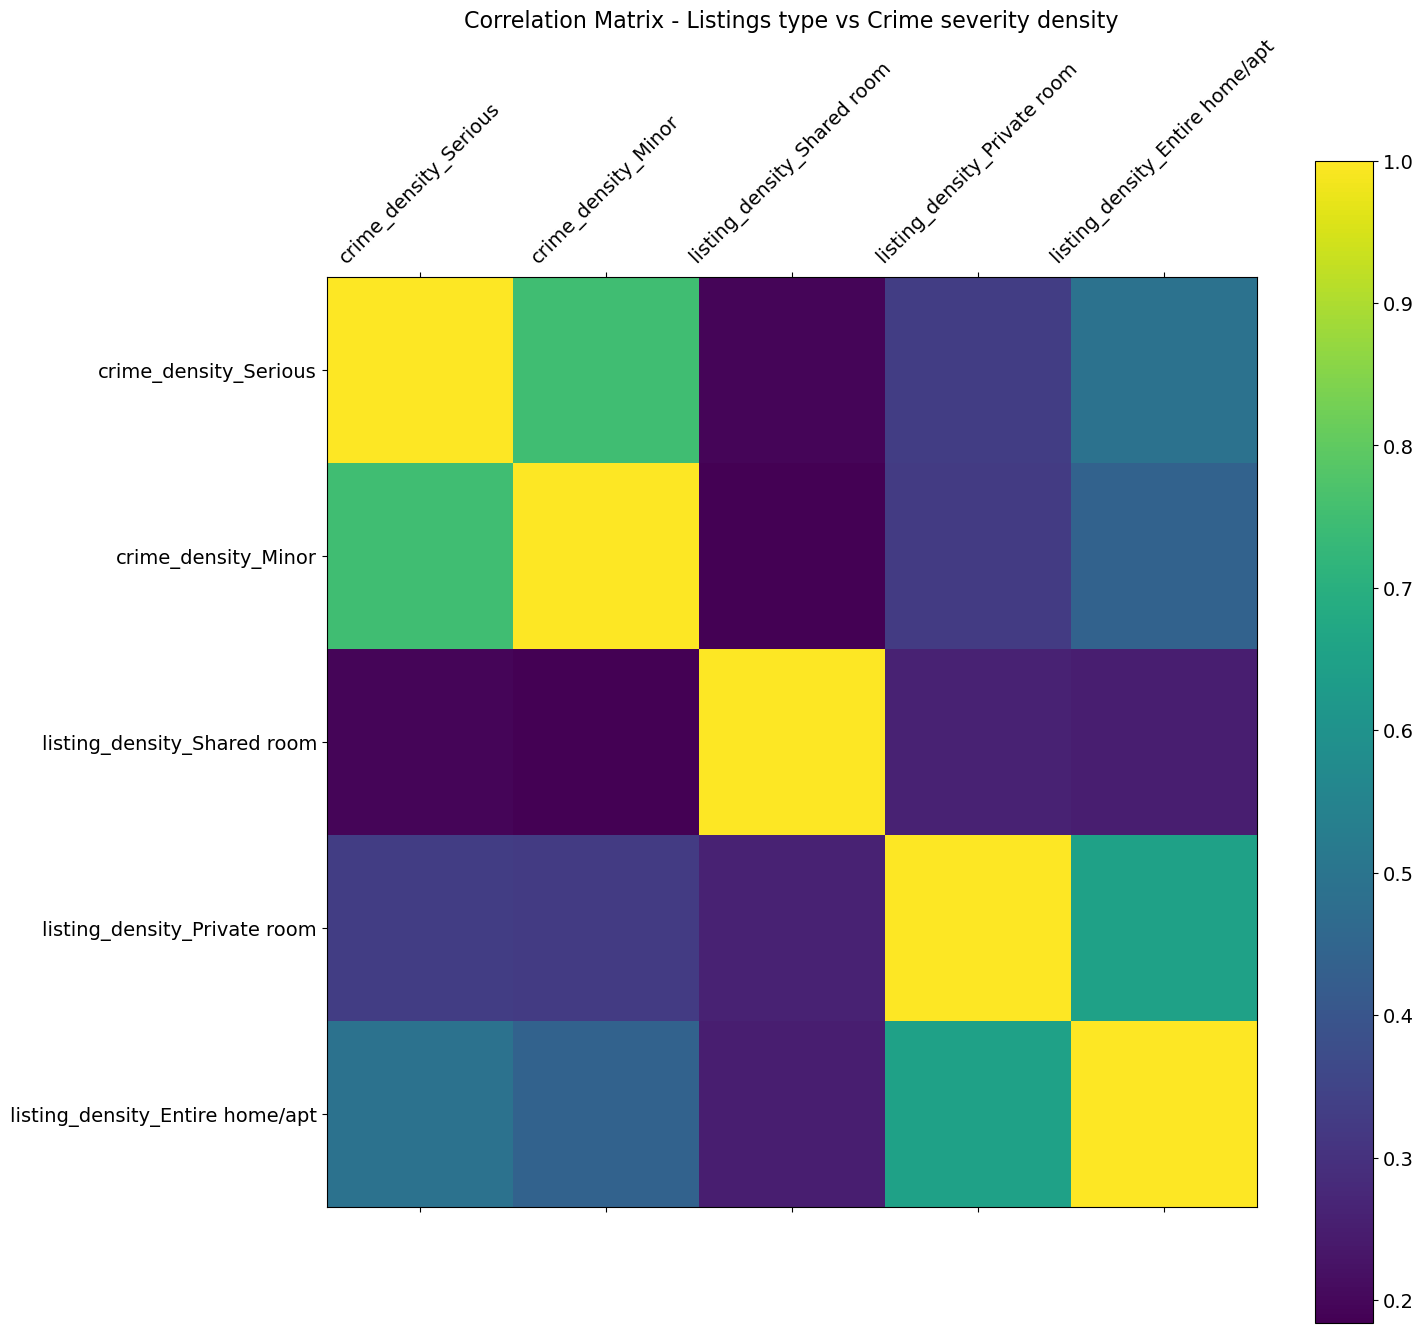

In [43]:
# Correlation matrix - Density
# Subset last 5 columns
lsoa_merge1_sub = lsoa_merge1.iloc[:,-5:]

f = plt.figure(figsize=(15, 15)) # creates a new figure, sets length and width

plt.matshow(lsoa_merge1_sub.corr(numeric_only=True), fignum=f.number) # matshow - creates matrix plot
plt.xticks(range(lsoa_merge1_sub.select_dtypes(['number']).shape[1]), lsoa_merge1_sub.select_dtypes(['number']).columns, fontsize=14, rotation=45) # add the x axis label
plt.yticks(range(lsoa_merge1_sub.select_dtypes(['number']).shape[1]), lsoa_merge1_sub.select_dtypes(['number']).columns, fontsize=14) # add the y axis label

# select_dtypes(['number']) - choose the numeric variables
cb = plt.colorbar() # add a legend to the right hand (default position)
cb.ax.tick_params(labelsize=14) # label size
plt.title('Correlation Matrix - Listings type vs Crime severity density', fontsize=16) # add the title

In [56]:
# Spatial aucorrelation with Local Moran's I
from libpysal.weights.contiguity import Queen
from libpysal import examples
import splot

y = lsoa_merge1['crime_density'].values
w = Queen.from_dataframe(lsoa_merge1)
w.transform = 'r'

In [60]:
from esda.moran import Moran
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

moran = Moran(y, w)
moran.I
moran.p_sim

0.001

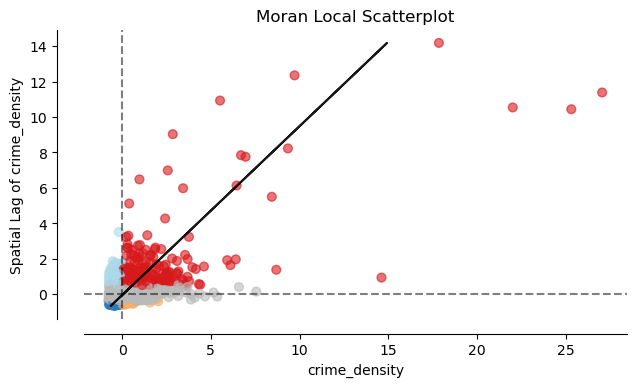

In [61]:
moran_loc = Moran_Local(y, w)
fig, ax = moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('crime_density')
ax.set_ylabel('Spatial Lag of crime_density')
plt.show()

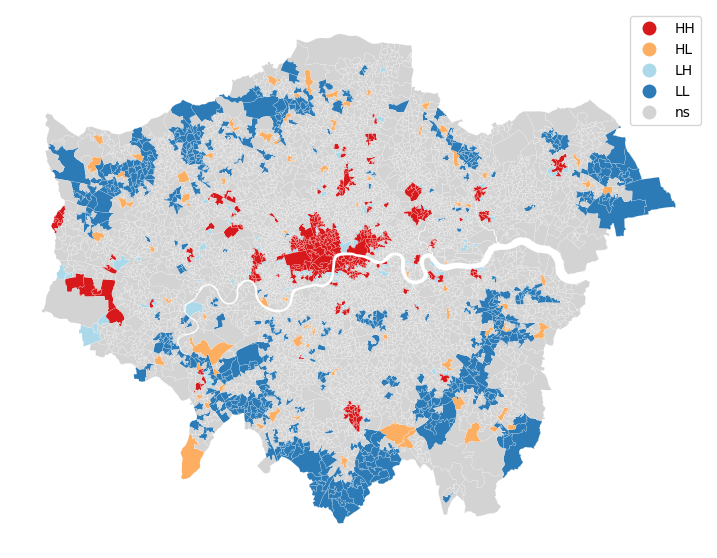

In [62]:
from splot.esda import lisa_cluster

lisa_cluster(moran_loc, lsoa_merge1, p=0.05, figsize = (9,9))
plt.show()

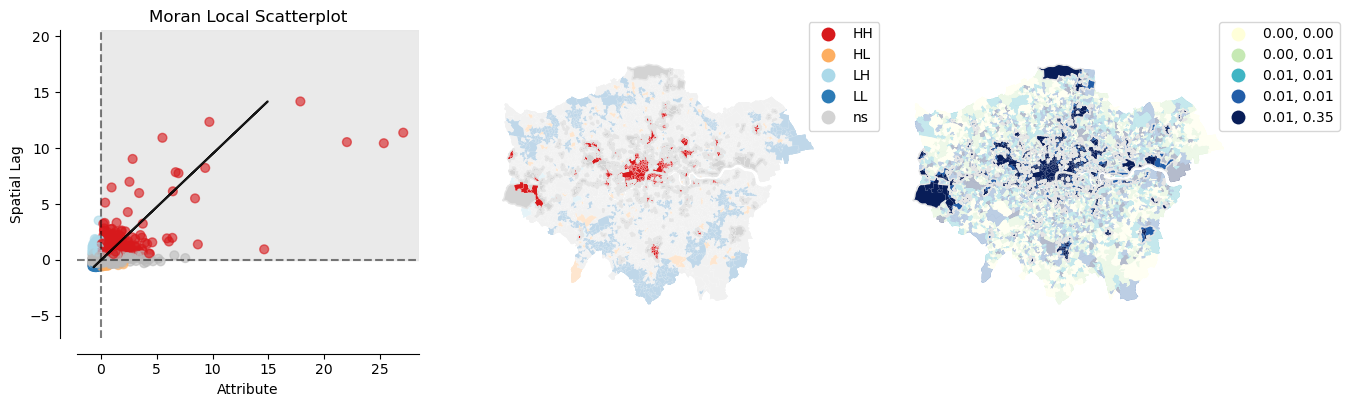

In [65]:
from splot.esda import plot_local_autocorrelation

plot_local_autocorrelation(moran_loc, lsoa_merge1, 'crime_density', quadrant=1)
plt.show()

[Explain the correlation between the number of listings and the number of crimes in each LSOA.] 300-400 words

### Inferring statistics (Question #7 - 45 points)

*Objective:* 
Show causation and infer recommendations

1. Step 1
2. Step 2
3. Step 3

*Notes:* 

- [From Kernel Density Estimation to Spatial Analysis In Python](https://towardsdatascience.com/from-kernel-density-estimation-to-spatial-analysis-in-python-64ddcdb6bc9b)
- [Airbnb and neighborhood crime: The incursion of tourists or the erosion of local social dynamics?](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8279333/): "We find evidence that increases in Airbnb listings led to more violence in neighborhoods in later years. This result supports the notion that the prevalence of Airbnb listings erodes the natural ability of a neighborhood to prevent crime, but does not support the interpretation that elevated numbers of tourists bring crime with them."
-------------------------------------------------------------------------------